In [1]:
# from bdd_utils import *
import matplotlib.pyplot as plt
import argparse
import os
from os import path
import string
import sys
import zipfile

from cv2 import imread, imwrite
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras.layers import Activation, BatchNormalization, Conv2D, \
    GlobalAveragePooling2D, MaxPooling2D, Dense, Input, add
from keras.layers import Conv2DTranspose, ReLU, Lambda, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.utils import Sequence, plot_model
import numpy as np

from ats.core import attention_sampling, multi_attention_sampling
from ats.utils.layers import L2Normalize, ResizeImages, SampleSoftmax, \
    ImageLinearTransform, ImagePan
from ats.utils.regularizers import multinomial_entropy
from ats.utils.training import Batcher

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from tensorflow import ConfigProto
from tensorflow import InteractiveSession
from tensorflow.python import debug as tf_debug
from keras.callbacks import TensorBoard
from bdd_utils import *
# from keras_resnet import models as resnet_models
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
sess = K.get_session()
sess = tf_debug.LocalCLIDebugWrapperSession(sess)
K.set_session(sess)

Using TensorFlow backend.
/home/pyhuang/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pyhuang/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pyhuang/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pyhuang/anaconda3

In [2]:
def neighPatches(samples, patch_size, image):
    lt = [0, 0]
    lt[0] = max(samples[0] - patch_size[0], 0)
    lt[1] = max(samples[1] - patch_size[1], 0)
    rb = [0, 0]
    rb[0] = min(samples[0] + 2*patch_size[0], image.shape[0])
    rb[1] = min(samples[1] + 2*patch_size[1], image.shape[1])
    # print("lr: ", lt)
    # print("rb: ", rb)
    crop_img = image[lt[0]:rb[0], lt[1]:rb[1]]
    return crop_img, lt, rb

(1280, 1920, 3)


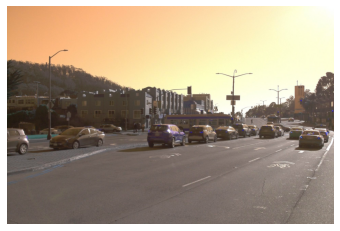

In [3]:
#path = '/home/sc/Documents/scene-cache/data/waymo_kitti/kitti_00000/image_0'
path = '/home/pyhuang/UM/data/kitti/image_0/'
f = 420
input_image = imread(path + str(f).zfill(15) + '.jpg')
print(input_image.shape)
resize_w = input_image.shape[1]
resize_h = input_image.shape[0]
plt.imshow(input_image)
plt.axis('off')
plt.show()
input_image = np.expand_dims(input_image, axis=0)

In [4]:
class options:
    def __init__(self, scale = 0.3, n_patches = 5, patch_size = (300, 300), regularizers_strength = 0.0001, load_dir = "/home/pyhuang/UM/attention/attention_sampling_keras/bdd100k_n5_p300_b4/", resume = True, load_epoch = 100, batch_size = 32, epochs = 500, momentum = 0.9, clipnorm = 1, lr = 0.001, optimizer = "adam", classes = []):
        self.scale = scale
        self.n_patches = n_patches
        self.patch_size = patch_size
        self.regularizers_strength = regularizers_strength
        self.load_dir = load_dir
        self.resume = resume
        self.load_epoch = load_epoch
        self.batch_size = batch_size
        self.epochs = epochs
        self.momentum = momentum
        self.clipnorm = clipnorm
        self.lr = lr
        self.optimizer = optimizer
        self.classes = classes

In [5]:
# attention_sampling model
opts = options(
    scale = 0.3,
    n_patches = 6,
    patch_size = (300, 300),
    regularizers_strength = 0.0001,
    # load_dir = "/home/pyhuang/UM/attention/attention-sampling/bdd100k_n15_p300_b4_de500_res50",
    load_dir = "/home/pyhuang/UM/attention/kitti_detection/",
    resume = True,
    load_epoch = 300,
    batch_size = 32,
    epochs = 500,
    momentum = 0.9,
    clipnorm = 1,
    lr = 0.001,
    optimizer = "adam",
    classes = ['empty', 'car']
)

In [6]:
def get_multi_model(outputs, scales, width, height, scale, n_patches, patch_size, reg):
    x_in = Input(shape=(height, width, 3))
    
    ats_input_layers = []
    for res_scale in scales:
        x_high = ImageLinearTransform()(x_in)
        x_high = ImagePan(horizontally=True, vertically=True)(x_high)
        x_high = ResizeImages((int(height/res_scale), int(width/res_scale)))(x_high)
        x_low = ResizeImages((int(height/res_scale*scale), int(width/res_scale*scale)))(x_high)
        ats_input_layers.append([res_scale, x_low, x_high])


    features, att, patches = multi_attention_sampling(
        attention,
        resnet,
        patch_size,
        n_patches,
        replace=False,
        attention_regularizer=multinomial_entropy(reg),
        receptive_field=9
    )(ats_input_layers)
    y = Dense(outputs, activation="softmax")(features)

    return (
        Model(inputs=x_in, outputs=[y]),
        Model(inputs=x_in, outputs=[att, patches, x_low])
    )

In [7]:
def attention(x):
    params = dict(
        activation="relu",
        padding="valid",
        kernel_regularizer=l2(1e-5)
    )
    x = Conv2D(8, kernel_size=3, **params)(x)
    x = Conv2D(16, kernel_size=3, **params)(x)
    x = Conv2D(32, kernel_size=3, **params)(x)
    x = Conv2D(1, kernel_size=3)(x)
    x = MaxPooling2D(pool_size=8)(x)
    x = SampleSoftmax(squeeze_channels=True, smooth=1e-4)(x)

    return x
# resnet50 = ResNet50(weights="imagenet", include_top=False)
# top = GlobalAveragePooling2D()(resnet50.output)
# top = L2Normalize()(top)
# resnet = Model(input=resnet50.input, output=top)
# for layer in resnet50.layers:
#     layer.trainable = False
def get_model(outputs,resnet, width, height, scale, n_patches, patch_size, reg):
    x_in = Input(shape=(height, width, 3))
    x_high = ImageLinearTransform()(x_in)
    x_high = ImagePan(horizontally=True, vertically=True)(x_high)
    x_low = ResizeImages((int(height*scale), int(width*scale)))(x_high)

    features, att, patches = attention_sampling(
        attention,
        resnet,
        patch_size,
        n_patches,
        replace=False,
        attention_regularizer=multinomial_entropy(reg),
        receptive_field=9
    )([x_low, x_high])
    y = Dense(outputs, activation="softmax")(features)

    return (
        Model(inputs=x_in, outputs=[y]),
        Model(inputs=x_in, outputs=[att, patches, x_low])
    )
def resnet(x, strides=[1, 2, 2, 2], filters=[32, 32, 32, 32]):
    """Implement a simple resnet."""
    # Do a convolution on x
    def c(x, filters, kernel, strides):
        return Conv2D(filters, kernel_size=kernel, strides=strides,
                      padding="same", use_bias=False)(x)

    # Do a BatchNorm on x
    def b(x):
        return BatchNormalization()(x)

    # Obviosuly just do relu
    def relu(x):
        return Activation("relu")(x)

    # Implement a resnet block. short is True when we need to add a convolution
    # for the shortcut
    def block(x, filters, strides, short):
        x = b(x)
        x = relu(x)
        x_short = x
        if short:
            x_short = c(x, filters, 1, strides)
        x = c(x, filters, 3, strides)
        x = b(x)
        x = relu(x)
        x = c(x, filters, 3, 1)
        x = add([x, x_short])

        return x

    # Implement the resnet
    stride_prev = strides.pop(0)
    filters_prev = filters.pop(0)
    y = c(x, filters_prev, 3, stride_prev)
    for s, f in zip(strides, filters):
        y = block(y, f, s, s != 1 or f != filters_prev)
        stride_prev = s
        filters_prev = f
    y = b(y)
    y = relu(y)

    # Average the final features and normalize them
    y = GlobalAveragePooling2D()(y)
    y = L2Normalize()(y)

    return y
    
def get_model(outputs, width, height, scale, n_patches, patch_size, reg):
    x_in = Input(shape=(height, width, 3))
    x_high = ImageLinearTransform()(x_in)
    x_high = ImagePan(horizontally=True, vertically=True)(x_high)
    x_low = ResizeImages((int(height*scale), int(width*scale)))(x_high)

    features, att, patches = attention_sampling(
        attention,
        resnet,
        patch_size,
        n_patches,
        replace=False,
        attention_regularizer=multinomial_entropy(reg),
        receptive_field=9
    )([x_low, x_high])
    y = Dense(outputs, activation="softmax")(features)

    # see a resnet18 for such image patch
    #image_input = Input(shape=(None, None, 3))
    # resnet18 = resnet_models.ResNet18(x_low, include_top=False, freeze_bn=True)
    # C5 = resnet18.outputs[-1]
    # drop_x = Dropout(rate=0.5)(C5)

    return (
        Model(inputs=x_in, outputs=[y]),
        Model(inputs=x_in, outputs=[att, patches, x_low])
        # Model(inputs=x_in, outputs=[drop_x])
    )
# model, att_model, res18_model = get_model(
model, att_model = get_multi_model(
    outputs = len(opts.classes), scales = [1, 2, 4],
    width = resize_w, height = resize_h, 
    scale = opts.scale,
    n_patches = opts.n_patches,
    patch_size = opts.patch_size,
    reg = opts.regularizers_strength
)
print(model.summary())
# print(resnet.summary())

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



ValueError: Input 0 of layer up_sampling2d is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 47, 71]

In [66]:
if opts.resume:
    load_path = os.path.join(opts.load_dir, "weights." + str(opts.load_epoch) + ".h5")
    model.load_weights(load_path)
    print("load model from ", load_path)
    model.trainable = False
    model.compile(
        loss="categorical_crossentropy",
        optimizer=get_optimizer(opts),
        metrics=["accuracy", "categorical_crossentropy"]
    )

load model from  /home/pyhuang/UM/attention/kitti_detection/weights.300.h5


In [67]:
x_low = model.layers[3].output
samples = model.layers[11].output
print(len(samples))
ats_map = model.layers[10].output
patch_features = model.layers[-3].output
expected_feature = model.layers[-2].output
ats_model = Model(model.input, [x_low, samples[0], samples[1], samples[2], samples[3], ats_map, patch_features, expected_feature, model.output])

4


In [68]:
def show_patches(patches, size):
    row, col = size
    figs, axs = plt.subplots(row, col)
    for i in range(len(patches)):
        r = i // col
        c = i % col
        axs[r, c].imshow(patches[i])
        axs[r, c].axis("off")
    # axs[0, 0].imshow(patches[0, 0])
    # axs[2, 2].imshow(image)
    # axs[2, 2].axis("off")
    plt.show()
    plt.clf()
    plt.close()

[[[11 33]
  [19 42]
  [ 5 65]
  [28 60]
  [ 9  5]
  [26 47]
  [ 0 66]
  [40 33]
  [42 62]
  [13 38]
  [ 7 46]
  [18 66]
  [31 16]
  [32  8]
  [23 46]]]
(1, 1280, 1920, 3)
[[[ 171  757]
  [ 384  996]
  [  11 1609]
  [ 623 1475]
  [ 118   11]
  [ 570 1129]
  [-122 1635]
  [ 942  757]
  [ 995 1529]
  [ 224  890]
  [  64 1103]
  [ 357 1635]
  [ 703  304]
  [ 729   91]
  [ 490 1103]]]


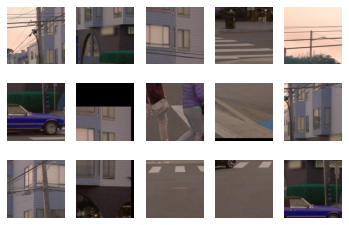

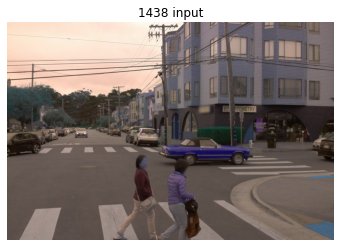

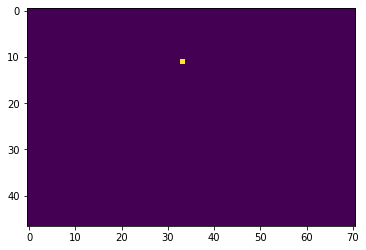

[[[13 24]
  [42 35]
  [ 5  8]
  [40 14]
  [ 1 68]
  [35 42]
  [42 38]
  [31 42]
  [34 58]
  [ 5 21]
  [19 22]
  [35 59]
  [45 23]
  [44 15]
  [ 3 29]]]
(1, 1280, 1920, 3)
[[[ 224  517]
  [ 995  810]
  [  11   91]
  [ 942  251]
  [ -95 1688]
  [ 809  996]
  [ 995  890]
  [ 703  996]
  [ 783 1422]
  [  11  437]
  [ 384  464]
  [ 809 1449]
  [1075  491]
  [1049  278]
  [ -42  650]]]


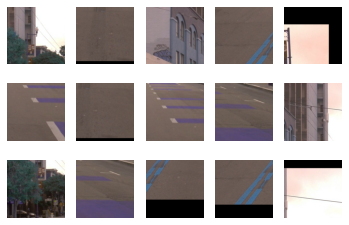

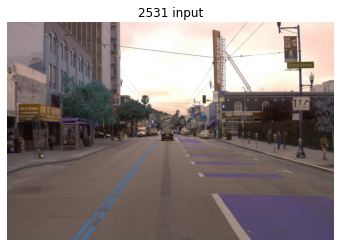

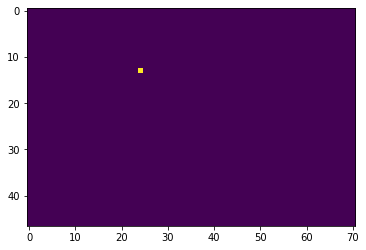

[[[11 33]
  [38 37]
  [35 65]
  [26  6]
  [38 22]
  [36 46]
  [ 7 27]
  [ 8 60]
  [ 3 54]
  [28 12]
  [25 61]
  [36 70]
  [14 58]
  [ 3 64]
  [13 69]]]
(1, 1280, 1920, 3)
[[[ 171  757]
  [ 889  863]
  [ 809 1609]
  [ 570   38]
  [ 889  464]
  [ 836 1103]
  [  64  597]
  [  91 1475]
  [ -42 1316]
  [ 623  198]
  [ 543 1502]
  [ 836 1742]
  [ 251 1422]
  [ -42 1582]
  [ 224 1715]]]


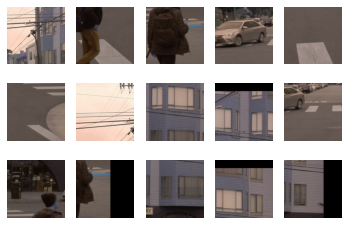

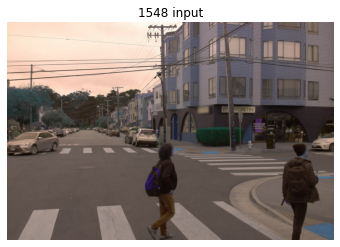

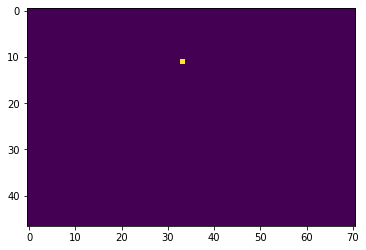

[[[32 47]
  [13 46]
  [40 60]
  [28 70]
  [ 5 54]
  [ 4 53]
  [42 13]
  [40 56]
  [31 14]
  [33 32]
  [43 55]
  [11 47]
  [21 41]
  [35 27]
  [ 9 14]]]
(1, 1280, 1920, 3)
[[[ 729 1129]
  [ 224 1103]
  [ 942 1475]
  [ 623 1742]
  [  11 1316]
  [ -15 1289]
  [ 995  224]
  [ 942 1369]
  [ 703  251]
  [ 756  730]
  [1022 1342]
  [ 171 1129]
  [ 437  970]
  [ 809  597]
  [ 118  251]]]


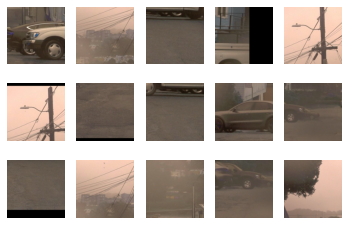

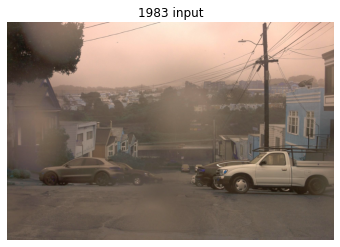

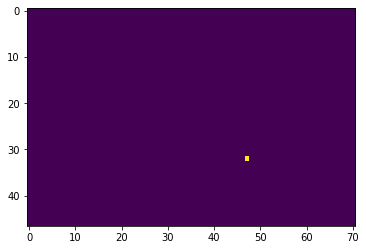

[[[28 34]
  [18 19]
  [16 48]
  [ 9 45]
  [43 14]
  [28 33]
  [12 25]
  [18 44]
  [25 23]
  [ 1 69]
  [44 26]
  [13 49]
  [14 70]
  [11 25]
  [28 14]]]
(1, 1280, 1920, 3)
[[[ 623  783]
  [ 357  384]
  [ 304 1156]
  [ 118 1076]
  [1022  251]
  [ 623  757]
  [ 197  544]
  [ 357 1050]
  [ 543  491]
  [ -95 1715]
  [1049  570]
  [ 224 1183]
  [ 251 1742]
  [ 171  544]
  [ 623  251]]]


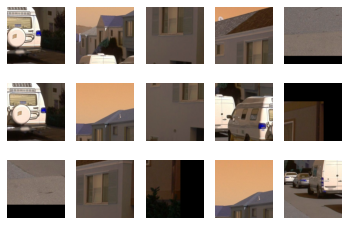

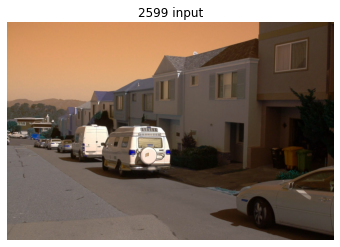

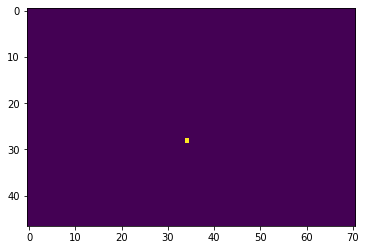

[[[39 54]
  [40 27]
  [ 1 65]
  [19  8]
  [ 7 62]
  [32 22]
  [10  1]
  [43 64]
  [ 7  9]
  [22 36]
  [11 25]
  [22 58]
  [15 52]
  [37 59]
  [15 70]]]
(1, 1280, 1920, 3)
[[[ 916 1316]
  [ 942  597]
  [ -95 1609]
  [ 384   91]
  [  64 1529]
  [ 729  464]
  [ 144  -95]
  [1022 1582]
  [  64  118]
  [ 463  837]
  [ 171  544]
  [ 463 1422]
  [ 277 1263]
  [ 862 1449]
  [ 277 1742]]]


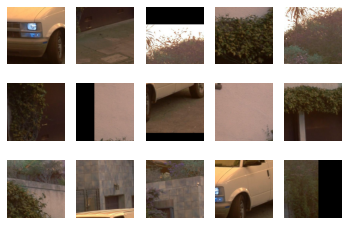

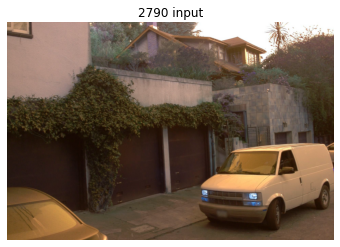

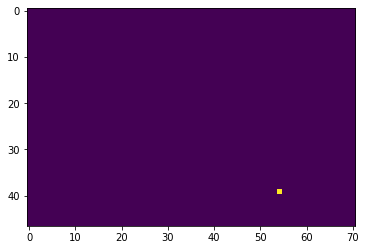

[[[15 59]
  [39 52]
  [ 9 69]
  [42 22]
  [35 42]
  [14 28]
  [44  9]
  [27 43]
  [18 25]
  [44 43]
  [ 3 19]
  [13 22]
  [25 21]
  [31  9]
  [24 58]]]
(1, 1280, 1920, 3)
[[[ 277 1449]
  [ 916 1263]
  [ 118 1715]
  [ 995  464]
  [ 809  996]
  [ 251  624]
  [1049  118]
  [ 596 1023]
  [ 357  544]
  [1049 1023]
  [ -42  384]
  [ 224  464]
  [ 543  437]
  [ 703  118]
  [ 517 1422]]]


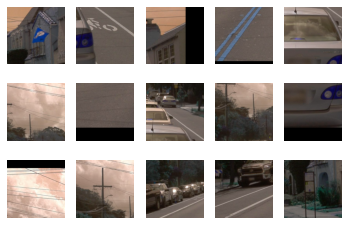

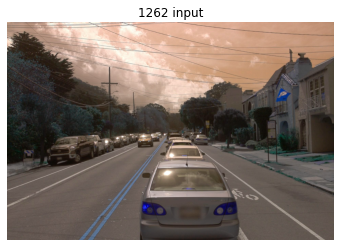

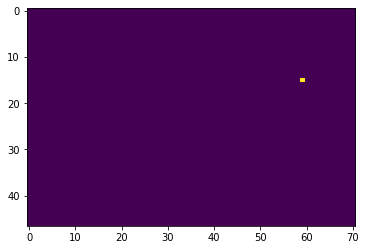

[[[22 39]
  [ 5 31]
  [12 22]
  [25 57]
  [ 8 48]
  [24 53]
  [42  1]
  [33 22]
  [17 70]
  [17 35]
  [21 30]
  [26 63]
  [30 50]
  [22 50]
  [ 3 11]]]
(1, 1280, 1920, 3)
[[[ 463  916]
  [  11  704]
  [ 197  464]
  [ 543 1396]
  [  91 1156]
  [ 517 1289]
  [ 995  -95]
  [ 756  464]
  [ 330 1742]
  [ 330  810]
  [ 437  677]
  [ 570 1555]
  [ 676 1209]
  [ 463 1209]
  [ -42  171]]]


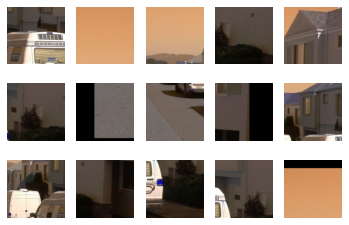

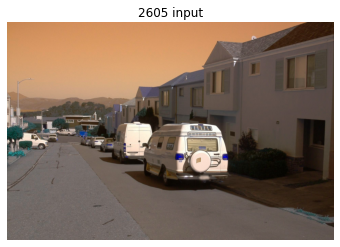

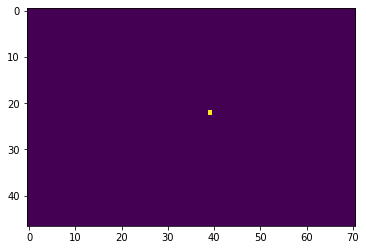

[[[20 59]
  [43 15]
  [21 54]
  [39 30]
  [32  3]
  [18 52]
  [40 51]
  [ 2 61]
  [ 8 30]
  [ 4 50]
  [ 8 56]
  [ 4 31]
  [31  2]
  [35 29]
  [10 53]]]
(1, 1280, 1920, 3)
[[[ 410 1449]
  [1022  278]
  [ 437 1316]
  [ 916  677]
  [ 729  -42]
  [ 357 1263]
  [ 942 1236]
  [ -69 1502]
  [  91  677]
  [ -15 1209]
  [  91 1369]
  [ -15  704]
  [ 703  -68]
  [ 809  650]
  [ 144 1289]]]


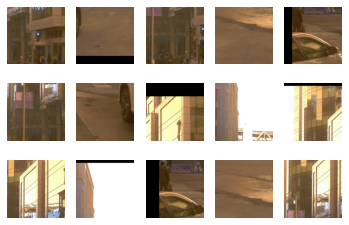

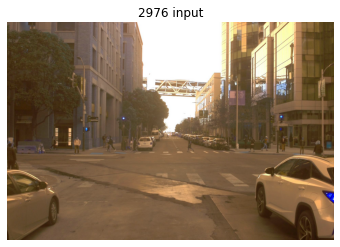

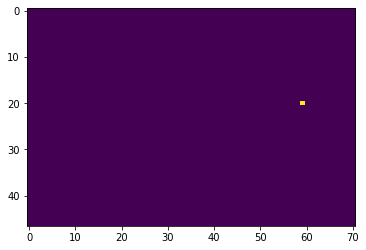

[[[28 32]
  [19 22]
  [11 48]
  [45 36]
  [45 22]
  [23 17]
  [ 9 64]
  [10 31]
  [37 70]
  [12 28]
  [ 5 69]
  [38 27]
  [ 7 16]
  [15 10]
  [ 1 19]]]
(1, 1280, 1920, 3)
[[[ 623  730]
  [ 384  464]
  [ 171 1156]
  [1075  837]
  [1075  464]
  [ 490  331]
  [ 118 1582]
  [ 144  704]
  [ 862 1742]
  [ 197  624]
  [  11 1715]
  [ 889  597]
  [  64  304]
  [ 277  145]
  [ -95  384]]]


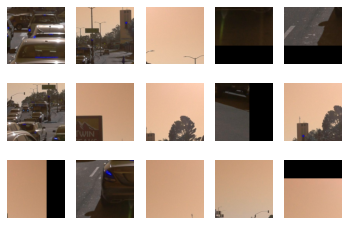

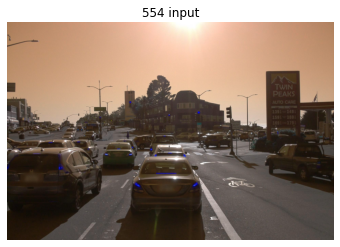

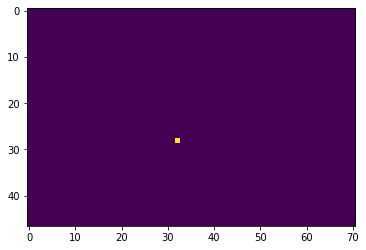

In [69]:
indice = np.random.randint(3175, size=10)
i = 0
while i < len(indice):
    f = indice[i]
    input_image = imread(path + str(f).zfill(15) + '.jpg')
    # print(str(f) + " :", input_image.shape)
    input_image = np.expand_dims(input_image, axis=0)
    low, patches, sampled_attention, high_samples,samples, ats_map, p_features, expected, y_pred = ats_model.predict(input_image)
    crops = []
    sample_lts = []
    sample_rbs = []
    # print(samples[0])
    # for sample in samples[0]:
    #     # print(sample)
    #     cropped, lt, rb = neighPatches(sample, opts.patch_size, input_image[0])
    #     sample_lts.append(lt)
    #     sample_rbs.append(rb)
    #     crops.append(cropped)
    # print(np.array(crops).shape)
    print(samples)
    print(input_image.shape)
    print(high_samples)
    show_patches(np.uint8(patches[0]), (2, 3))
    plt.imshow(input_image[0])
    plt.axis("off")
    plt.title(str(f)+" input")
    plt.show()
    plt.imshow(ats_map[0])
    plt.show()
    i += 1